In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import necessery libraries

In [2]:
import os
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt

# Data PreProcessing

In [3]:
from torch.utils.data import TensorDataset,DataLoader
directory="/kaggle/input/titanic/"
csv_file='train.csv'
csv_path=os.path.join(directory,csv_file)
train_data=pd.read_csv(csv_path)
train=train_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
train.dropna(axis=0, inplace=True)
train= pd.get_dummies(train,columns=['Pclass','Sex','SibSp','Parch','Embarked'])
X=train.drop(['Survived'],axis=1)
X=torch.tensor(X.values.astype(np.float32))
Y=torch.tensor(train['Survived'].values.astype(np.float32))
Y=Y.reshape([-1, 1])
dataset=TensorDataset(X,Y)
trainloader=DataLoader(dataset,batch_size=100,shuffle=False)

# Defing The NeuralNetwork Class 

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.NN=nn.Sequential(nn.Linear(23,100),nn.ReLU(),
                              nn.Linear(100,10),nn.ReLU(),
                              nn.Linear(10,10),nn.ReLU(),
                              nn.Linear(10,10),nn.ReLU(),
                              nn.Linear(10,1),nn.Sigmoid())
    def forward(self,x):
        yhat=self.NN(torch.Tensor(x))
        return yhat


# Training the first virsion of the model

 58%|█████▊    | 1151/2000 [00:19<00:14, 60.07it/s]


tensor(0.0199, grad_fn=<BinaryCrossEntropyBackward0>)


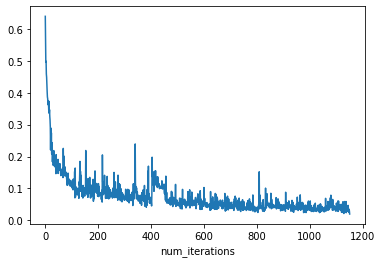

In [5]:
from tqdm import tqdm
model=Model()
torch.manual_seed(1)
criterion=nn.BCELoss()
losses=[]
num_iterations=2000
optimizer=optim.Adam(model.parameters(),lr=0.005)
loss=0
for i in tqdm(range(num_iterations)):
    for x,y in trainloader:
        yhat=model(x)
        loss=criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss)
    if loss<=0.02:
        break
plt.plot(torch.tensor(losses).numpy())
plt.xlabel('num_iterations')
#plt.plot(lrs)
print(losses[-1])

# Processing the test data

In [6]:
csv_file='test.csv'
csv_path=os.path.join(directory,csv_file)
test_data=pd.read_csv(csv_path)
test=train_data.drop(['Name','Ticket','Cabin'],axis=1)
csv_file='gender_submission.csv'
csv_path=os.path.join(directory,csv_file)
test_labels=pd.read_csv(csv_path)
test=pd.concat([test,test_labels])
test=test.drop('PassengerId',axis=1)
test= pd.get_dummies(test,columns=[ 'Pclass','Sex','SibSp','Parch','Embarked'])
test=test.drop('SibSp_8.0',axis=1)
test=test.dropna(axis=0)
X=test.drop(['Survived'],axis=1)
X=torch.tensor(X.values.astype(np.float32))
Y=torch.tensor(test['Survived'].values.astype(np.float32))
Y=Y.reshape([-1, 1])
dataset=TensorDataset(X,Y)
testloader=DataLoader(dataset,batch_size=100,shuffle=False)

# Testing the model on the validation dataset

**note we took half of thee testing data as a validation set

In [7]:
for i,epoch in enumerate(testloader):
    x,y=epoch
    if i==0:
        yhat=model(x)
    else:
        yhat=torch.cat((yhat,model(x)),dim=0)
loss=criterion(yhat[357:715],Y[357:715])
print(loss)


tensor(0.2336, grad_fn=<BinaryCrossEntropyBackward0>)


# Improving the model by changing the Hyperparameters & testing

**1) Using Adamax Optimizer**

 83%|████████▎ | 1651/2000 [00:28<00:06, 57.44it/s]


tensor(0.0181, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1585, grad_fn=<BinaryCrossEntropyBackward0>)


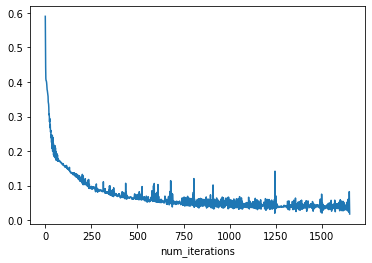

In [8]:
from tqdm import tqdm
model=Model()
torch.manual_seed(1)
criterion=nn.BCELoss()
losses=[]
num_iterations=2000
optimizer=optim.Adamax(model.parameters(),lr=0.005)
loss=0
for i in tqdm(range(num_iterations)):
    for x,y in trainloader:
        yhat=model(x)
        loss=criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss)
    if loss<=0.02:
        break
plt.plot(torch.tensor(losses).numpy())
plt.xlabel('num_iterations')
print(losses[-1])
for i,epoch in enumerate(testloader):
    x,y=epoch
    if i==0:
        yhat=model(x)
    else:
        yhat=torch.cat((yhat,model(x)),dim=0)
loss=criterion(yhat[357:715],Y[357:715])
print(loss)

**2) Using AdamW Optimizer**

 41%|████      | 823/2000 [00:14<00:20, 58.54it/s]


tensor(0.0170, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1880, grad_fn=<BinaryCrossEntropyBackward0>)


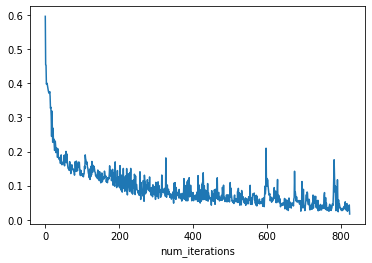

In [9]:
from tqdm import tqdm
model=Model()
torch.manual_seed(1)
criterion=nn.BCELoss()
losses=[]
num_iterations=2000
optimizer=optim.AdamW(model.parameters(),lr=0.005)
loss=0
lrs = []
#lambda1 = lambda epoch: 0.1 ** epoch
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
for i in tqdm(range(num_iterations)):
    for x,y in trainloader:
        yhat=model(x)
        loss=criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        #lrs.append(optimizer.param_groups[0]["lr"])
    losses.append(loss)
    if loss<=0.02:
        break
plt.plot(torch.tensor(losses).numpy())
plt.xlabel('num_iterations')
#plt.plot(lrs)
print(losses[-1])
for i,epoch in enumerate(testloader):
    x,y=epoch
    if i==0:
        yhat=model(x)
    else:
        yhat=torch.cat((yhat,model(x)),dim=0)
loss=criterion(yhat[357:715],Y[357:715])
print(loss)

Adam was the best optimizer when applying on the validation data

**3) Trying different learning rates to select the best one**

In [10]:
from tqdm import tqdm
model=Model()
torch.manual_seed(1)
criterion=nn.BCELoss()
num_iterations=2000


lrs = [0.001,0.002,0.003,.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,
       0.04,0.05,0.06,0.07,0.08,0.09]
trainlosses=[]
validationlosses=[]
for lr in lrs:
    trainloss=0
    optimizer=optim.Adam(model.parameters(),lr=lr)
    for i in range(num_iterations):
        for x,y in trainloader:
            yhat=model(x)
            trainloss=criterion(yhat,y)
            optimizer.zero_grad()
            trainloss.backward()
            optimizer.step()
        if trainloss<=0.02:
            break
    trainlosses.append(trainloss)   
    for j,epoch in enumerate(testloader):
        x,y=epoch
        if j==0:
            yhat=model(x)
        else:
            yhat=torch.cat((yhat,model(x)),dim=0)
    validationloss=criterion(yhat[0:357],Y[0:357])
    validationlosses.append(validationloss)
    print(f'lr:{lr},trainloss:{trainlosses[-1]},validationloss:{validationloss}')

    

lr:0.001,trainloss:0.017336323857307434,validationloss:0.3531527817249298
lr:0.002,trainloss:0.014065171591937542,validationloss:0.21685895323753357
lr:0.003,trainloss:0.017718467861413956,validationloss:0.40012669563293457
lr:0.004,trainloss:0.019608067348599434,validationloss:0.22653056681156158
lr:0.005,trainloss:0.019305424764752388,validationloss:0.2198958843946457
lr:0.006,trainloss:0.019152911379933357,validationloss:0.37491294741630554
lr:0.007,trainloss:0.01968357153236866,validationloss:0.20520934462547302
lr:0.008,trainloss:0.019258948042988777,validationloss:0.22170531749725342
lr:0.009,trainloss:0.01983361691236496,validationloss:0.185808002948761
lr:0.01,trainloss:0.019785186275839806,validationloss:0.212104931473732
lr:0.02,trainloss:0.06816337257623672,validationloss:0.2969115972518921
lr:0.03,trainloss:0.646988570690155,validationloss:0.6598384380340576
lr:0.04,trainloss:0.6474331021308899,validationloss:0.6584092974662781
lr:0.05,trainloss:0.6475715041160583,validatio

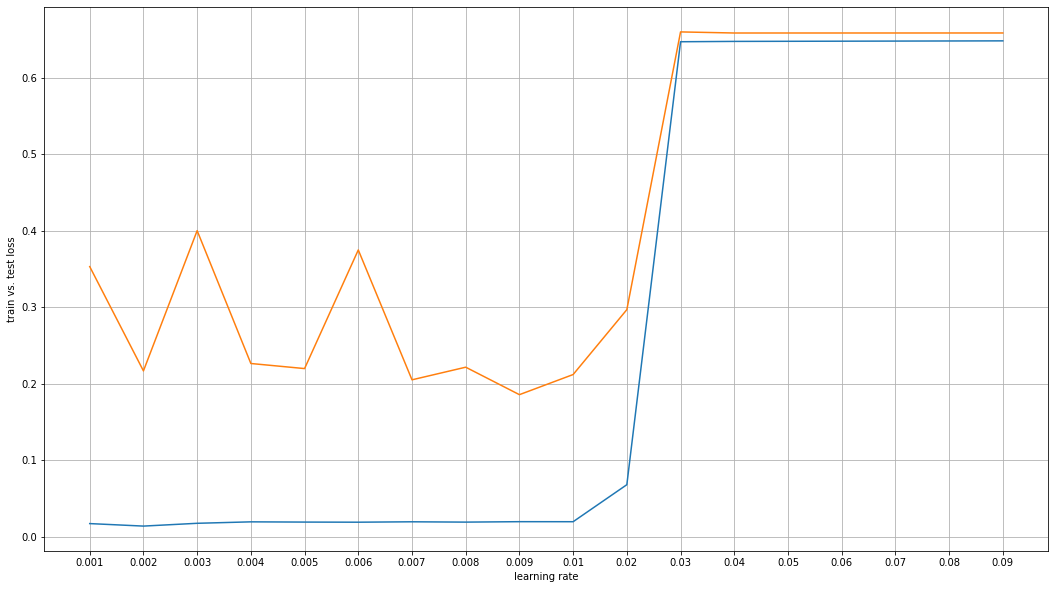

In [11]:
plt.figure(figsize=(18,10))
plt.plot(list(map(str,lrs)),torch.tensor(trainlosses).detach().numpy())
plt.plot(list(map(str,lrs)),torch.tensor(validationlosses).detach().numpy())
plt.xlabel('learning rate')
plt.ylabel('train vs. test loss')
plt.grid()

The best learning rate for the validation data was found on lr=0.005

# Training the model using the selected Hyperparameters

In [12]:
from tqdm import tqdm
model=Model()
torch.manual_seed(1)
criterion=nn.BCELoss()
losses=[]
num_iterations=2000
optimizer=optim.Adam(model.parameters(),lr=0.003)
loss=0
for i in tqdm(range(num_iterations)):
    for x,y in trainloader:
        yhat=model(x)
        loss=criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss)
    if loss<=0.02:
        break
print(f'train_loss: {losses[-1]}')
for i,epoch in enumerate(testloader):
    x,y=epoch
    if i==0:
        yhat=model(x)
    else:
        yhat=torch.cat((yhat,model(x)),dim=0)
loss=criterion(yhat[357:715],Y[357:715])
print(f'test_loss: {loss}')

 40%|████      | 801/2000 [00:13<00:20, 58.84it/s]

train_loss: 0.01476410310715437
test_loss: 0.33065393567085266


# Submit the final results

In [13]:

pd.DataFrame({'Survived': Y.reshape(-1).detach().numpy(), 'Predected_Survived': yhat.reshape(-1).detach().numpy()})

,Survived,Predected_Survived
0,0.0,5.151777e-02
1,1.0,1.000000e+00
2,1.0,4.294955e-01
3,1.0,1.000000e+00
4,0.0,1.583051e-02
...,...,...
709,0.0,1.776576e-08
710,0.0,5.575474e-03
711,1.0,1.000000e+00
712,1.0,9.999343e-01


In [14]:
my_submission = pd.DataFrame({'Survived': Y.reshape(-1).detach().numpy(), 'Predected_Survived': yhat.reshape(-1).detach().numpy()})
my_submission.to_csv('submission.csv',index=False)